In [1]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [2]:
dataset = NWBDataset('/home/dmifsud/Projects/NDT-U/data/mc_rtt_train.nwb', split_heldout=False)

In [3]:
## Make trial data

# Find when target pos changes
has_change = dataset.data.target_pos.fillna(-1000).diff(axis=0).any(axis=1) # filling NaNs with arbitrary scalar to treat as one block
# Find if target pos change corresponds to NaN-padded gap between files
change_nan = dataset.data[has_change].isna().any(axis=1)
# Drop trials containing the gap and immediately before and after, as those trials may be cut short
drop_trial = (change_nan | change_nan.shift(1, fill_value=True) | change_nan.shift(-1, fill_value=True))[:-1]
# Add start and end times to trial info
change_times = dataset.data.index[has_change]
start_times = change_times[:-1][~drop_trial]
end_times = change_times[1:][~drop_trial]
# Get target position per trial
target_pos = dataset.data.target_pos.loc[start_times].to_numpy().tolist()
# Compute reach distance and angle
reach_dist = dataset.data.target_pos.loc[end_times - pd.Timedelta(1, 'ms')].to_numpy() - dataset.data.target_pos.loc[start_times - pd.Timedelta(1, 'ms')].to_numpy()
reach_angle = np.arctan2(reach_dist[:, 1], reach_dist[:, 0]) / np.pi * 180
# Create trial info
dataset.trial_info = pd.DataFrame({
    'trial_id': np.arange(len(start_times)),
    'start_time': start_times,
    'end_time': end_times,
    'target_pos': target_pos,
    'reach_dist_x': reach_dist[:, 0],
    'reach_dist_y': reach_dist[:, 1],
    'reach_angle': reach_angle,
})

speed = np.linalg.norm(dataset.data.finger_vel, axis=1)
dataset.data['speed'] = speed
peak_times = dataset.calculate_onset('speed', 0.05)

trial_data = dataset.make_trial_data(align_field='speed_onset', align_range=(-290, 750), allow_nans=True)
len(trial_data.trial_id.unique())

Shortened 21 trials to prevent overlap.


168

In [ ]:
    # ax[0].plot(range(len(trial.finger_vel.x)), trial.finger_vel.x, color='tab:blue') #row=0, col=0
    # ax[1].plot(range(len(trial.finger_vel.y)), trial.finger_vel.y, color='tab:blue') #row=1, col=0
    # ax[0].plot(range(len(trial.finger_vel.x)), trial.finger_vel.x, f'{colors.rgb2hex(mapper.to_rgba(angle))}') #row=0, col=0
        # angle = dataset.trial_info[dataset.trial_info.trial_id == tid].reach_angle

    # ax[1].plot(range(len(trial.finger_vel.y)), trial.finger_vel.y, f'{colors.rgb2hex(mapper.to_rgba(angle))}') #row=1, col=0

Allowed 17 overlapping trials.
Allowed 8 overlapping trials.


381
134


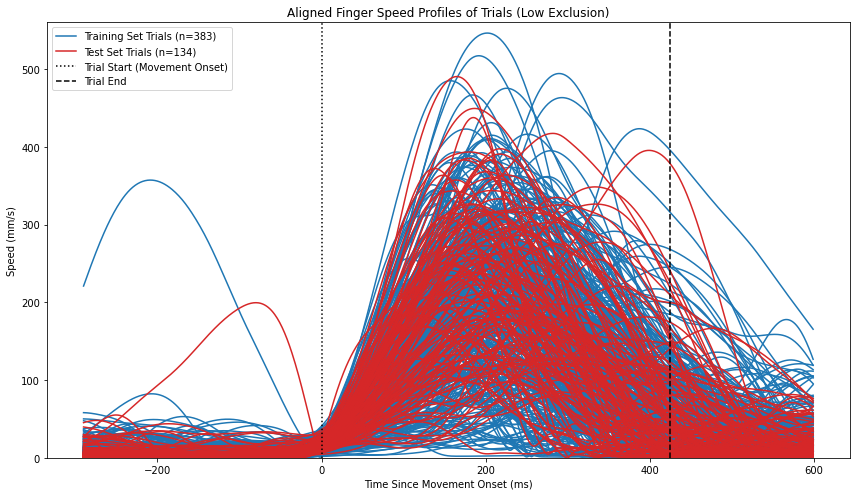

In [18]:
has_change = dataset.data.target_pos.fillna(-1000).diff(axis=0).any(axis=1) # filling NaNs with arbitrary scalar to treat as one block
change_nan = dataset.data[has_change].isna().any(axis=1)
change_times = dataset.data.index[has_change]
mask = (change_nan.index >= "00:08:06.900000")

drop_trial_train = (change_nan | change_nan.shift(1, fill_value=True) | change_nan.shift(-1, fill_value=True) | mask)[:-1]
drop_trial_test = (change_nan | change_nan.shift(1, fill_value=True) | change_nan.shift(-1, fill_value=True) | ~mask)[:-1]

start_times_train = change_times[:-1][~drop_trial_train]
end_times_train = change_times[1:][~drop_trial_train]

start_times_test = change_times[:-1][~drop_trial_test]
end_times_test = change_times[1:][~drop_trial_test]

target_pos_train = dataset.data.target_pos.loc[start_times_train].to_numpy().tolist()
target_pos_test = dataset.data.target_pos.loc[start_times_test].to_numpy().tolist()

reach_dist_train = dataset.data.target_pos.loc[end_times_train - pd.Timedelta(1, 'ms')].to_numpy() - dataset.data.target_pos.loc[start_times_train - pd.Timedelta(1, 'ms')].to_numpy()
reach_dist_test = dataset.data.target_pos.loc[end_times_test - pd.Timedelta(1, 'ms')].to_numpy() - dataset.data.target_pos.loc[start_times_test - pd.Timedelta(1, 'ms')].to_numpy()

reach_angle_train = np.arctan2(reach_dist_train[:, 1], reach_dist_train[:, 0]) / np.pi * 180
reach_angle_test = np.arctan2(reach_dist_test[:, 1], reach_dist_test[:, 0]) / np.pi * 180

import copy
dataset_train = copy.deepcopy(dataset)
dataset_test = copy.deepcopy(dataset)

dataset_train.trial_info = pd.DataFrame({
    'trial_id': np.arange(len(start_times_train)),
    'start_time': start_times_train,
    'end_time': end_times_train,
    'target_pos': target_pos_train,
    'reach_dist_x': reach_dist_train[:, 0],
    'reach_dist_y': reach_dist_train[:, 1],
    'reach_angle': reach_angle_train,
})
dataset_test.trial_info = pd.DataFrame({
    'trial_id': np.arange(len(start_times_test)),
    'start_time': start_times_test,
    'end_time': end_times_test,
    'target_pos': target_pos_test,
    'reach_dist_x': reach_dist_test[:, 0],
    'reach_dist_y': reach_dist_test[:, 1],
    'reach_angle': reach_angle_test,
})

speed = np.linalg.norm(dataset_train.data.finger_vel, axis=1)
dataset_train.data['speed'] = speed
peak_times = dataset_train.calculate_onset(
    'speed', 
    onset_threshold=0.075, 
    peak_prominence=0.9,
    peak_distance_s=0.9,
    multipeak_threshold=0.9
)

speed = np.linalg.norm(dataset_test.data.finger_vel, axis=1)
dataset_test.data['speed'] = speed
peak_times = dataset_test.calculate_onset(
    'speed', 
    onset_threshold=0.075, 
    peak_prominence=0.9,
    peak_distance_s=0.9,
    multipeak_threshold=0.9
)

# train_trial_data = dataset_train.make_trial_data(align_field='start_time', align_range=(0, 900), allow_nans=False, allow_overlap=True)
train_trial_data = dataset_train.make_trial_data(align_field='speed_onset', align_range=(-290, 600), allow_nans=False, allow_overlap=True)
print(len(train_trial_data.trial_id.unique()))

# test_trial_data = dataset_test.make_trial_data(align_field='start_time', align_range=(0, 900), allow_nans=False, allow_overlap=True)
test_trial_data = dataset_test.make_trial_data(align_field='speed_onset', align_range=(-290, 600), allow_nans=False, allow_overlap=True)
print(len(test_trial_data.trial_id.unique()))


fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plt.xlabel('Time Since Movement Onset (ms)')
plt.ylabel('Speed (mm/s)')
plt.ylim([0, 560])
plt.title('Aligned Finger Speed Profiles of Trials (Low Exclusion)')
first_train, first_test = False, False
for tid, trial in train_trial_data.groupby('trial_id'):
    speed = np.linalg.norm(trial.finger_vel, axis=1)
    ax.plot(range(-290,len(speed)-290), speed, color='tab:blue', label='Training Set Trials (n=383)' if not first_train else None) #row=0, col=0
    first_train = True
for tid, trial in test_trial_data.groupby('trial_id'):
    speed = np.linalg.norm(trial.finger_vel, axis=1)
    ax.plot(range(-290,len(speed)-290), speed, color='tab:red', label='Test Set Trials (n=134)' if not first_test else None) #row=0, col=0
    first_test = True
plt.plot([0 for i in range(1000)], [i for i in range(1000)], linestyle='dotted', color='black', label='Trial Start (Movement Onset)')
plt.plot([425 for i in range(1000)], [i for i in range(1000)], linestyle='dashed', color='black', label='Trial End')

plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig('low_exclusion.png', facecolor='white', transparent=False)

In [6]:
from scipy import signal
from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt
import numpy as np

In [7]:
window = signal.gaussian(36, std=6, sym=False)
window


array([0.00131331, 0.00218749, 0.00356995, 0.0057084 , 0.00894342,
       0.01372872, 0.02064872, 0.03042937, 0.04393693, 0.0621589 ,
       0.08616161, 0.11702026, 0.15572029, 0.2030328 , 0.25937256,
       0.32465247, 0.39815322, 0.47843023, 0.56327935, 0.64977934,
       0.73442054, 0.81331837, 0.8824969 , 0.9382156 , 0.97730237,
       0.99745223, 0.99745223, 0.97730237, 0.9382156 , 0.8824969 ,
       0.81331837, 0.73442054, 0.64977934, 0.56327935, 0.47843023,
       0.39815322, 0.32465247, 0.25937256, 0.2030328 , 0.15572029,
       0.11702026, 0.08616161, 0.0621589 , 0.04393693, 0.03042937,
       0.02064872, 0.01372872, 0.00894342, 0.0057084 , 0.00356995,
       0.00218749])

In [211]:
(np.random.randn(1000) < np.sin(np.linspace(0, 10, 1000)))*1

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,

In [235]:
np.random.poisson(0.25, 1000)

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 1, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1,
       0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 2, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 2,

In [246]:
for i in np.sin(np.linspace(0, 10, 1000)):
    print(i + 0.0001)

0.0001
0.010109842843179184
0.020118682705473477
0.030125516706496137
0.040129342166846646
0.05012915670857863
0.06012395835563764
0.07011274563425858
0.0800945176733128
0.09006827430459496
0.10003301616303925
0.10998774478685526
0.1199314627175733
0.12986317359998925
0.13978188228199884
0.1496865949143112
0.1595763190500322
0.169450063744107
0.17930683965261232
0.18914565913188802
0.19896553633749853
0.20876548732301403
0.21854453013860112
0.22830168492941394
0.23803597403377497
0.24774642208113615
0.25743205608981057
0.26709190556446466
0.2767250025933614
0.2863303819453445
0.2959070811665539
0.30545414067686344
0.3149706038660299
0.3244555171895452
0.33390793026418075
0.34332689596321564
0.35271147051133783
0.36206071357921044
0.37137368837769164
0.380649461751701
0.38988710427372075
0.3990856903369241
0.4082442982479204
0.4173620103191085
0.42643791296062844
0.4354710967719027
0.44446065663275763
0.45340569179411605
0.46230530596825165
0.4711586074185969
0.4799647090490943
0.488722

torch.Size([1, 1, 6])
torch.Size([1, 6])
[0, 0, 0, 1, 0, 0, 0]
[[0.01755951 0.12974823 0.35269225 0.35269225 0.12974823 0.01755951]]


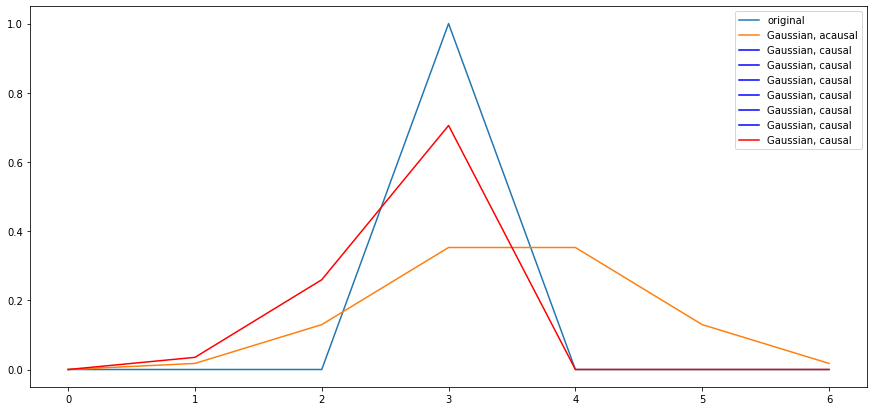

In [11]:
# %%
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# %%
# generate a noisy sine wave
# data = (np.random.randn(1000) <  * np.sin(np.linspace(0, 10, 1000)))*1
# data = [np.random.poisson(i * 0.1 + 0.00000001) for i in np.exp(np.sin(np.linspace(0, 10, 1000)))]
data = [0, 0, 0, 1, 0, 0, 0]
# data = np.random.poisson(0.25, 1000)
plt_1 = plt.figure(figsize=(15, 7))

# make the Gaussian window we normally use
gauss_bin_std = 1  # bins
win_len = int(6 * gauss_bin_std)
window = signal.gaussian(win_len, gauss_bin_std, sym=True)
window /= np.sum(window)
# make a causal "Gaussian" window by zeroing out the right side
causal_window = window.copy()
causal_window = causal_window[:len(causal_window) // 2]
causal_window /= np.sum(causal_window)
# make a causal exponential window
# exp_window = signal.windows.exponential(win_len, tau=12)
# exp_window[len(exp_window) // 2:] = 0
# exp_window /= np.sum(exp_window)

import torch.nn as nn
import torch

gauss_bin_std = 1  # bins
win_len = int(6 * gauss_bin_std)
window = signal.gaussian(win_len, gauss_bin_std, sym=True)
window /= np.sum(window)
# Extract spiking data
conv2d = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=6, bias=False, padding=2)
# x = torch.Tensor(window).repeat(data.shape[0], data.shape[0], 1)
x = torch.Tensor(window).unsqueeze(dim=0).unsqueeze(dim=0)
print(x.shape)
conv2d.weight = nn.Parameter(x) # You can set anything you want.
model = nn.Sequential(conv2d)
with torch.no_grad(): res = model(torch.Tensor(data).unsqueeze(dim=0))
print(res.shape)
print(data)
print(res.numpy())

# plot the original data
plt.plot(data, label='original')
# plot the Gaussian-smoothed data
plt.plot(signal.convolve(data, window, mode='same'), label='Gaussian, acausal')
# plot the data smoothed by a causal "Gaussian" window
plt.plot(res.numpy(),
         label='Gaussian, causal', color='b')
causal_window = window.copy()
causal_window[len(causal_window) // 2:] = 0
causal_window /= np.sum(causal_window)
plt.plot(signal.convolve(data, causal_window, mode='same'),
         label='Gaussian, causal', color='r')
# plot the data smoothed by an exponential window
# plt.plot(signal.convolve(data, exp_window, mode='same'),
#          label='exponential, causal')
plt.legend()
plt.savefig('smoothing_methods.png')

# %%
# plot the windows
# plt.plot(window, color='C1', label='Gaussian, acausal')
# plt.plot(causal_window, color='C2', label='Gaussian, causal')
# plt.plot(exp_window, color='C3', label='exponential, causal')
plt.legend()
plt.savefig('smoothing_windows.png')
# %%

In [156]:
window = signal.gaussian(6, 1, sym=True)
print(window)
window /= np.sum(window)
print(window)

[0.04393693 0.32465247 0.8824969  0.8824969  0.32465247 0.04393693]
[0.01755951 0.12974823 0.35269226 0.35269226 0.12974823 0.01755951]


In [157]:
causal_window = window.copy()
causal_window[len(causal_window) // 2:] = 0
print(causal_window)
causal_window /= np.sum(causal_window)
print(causal_window)

[0.01755951 0.12974823 0.35269226 0.         0.         0.        ]
[0.03511903 0.25949646 0.70538451 0.         0.         0.        ]


In [159]:
cut_causal_window = window[:len(window) // 2].copy()
print(cut_causal_window)
cut_causal_window /= np.sum(cut_causal_window)
print(cut_causal_window)

[0.01755951 0.12974823 0.35269226]
[0.03511903 0.25949646 0.70538451]


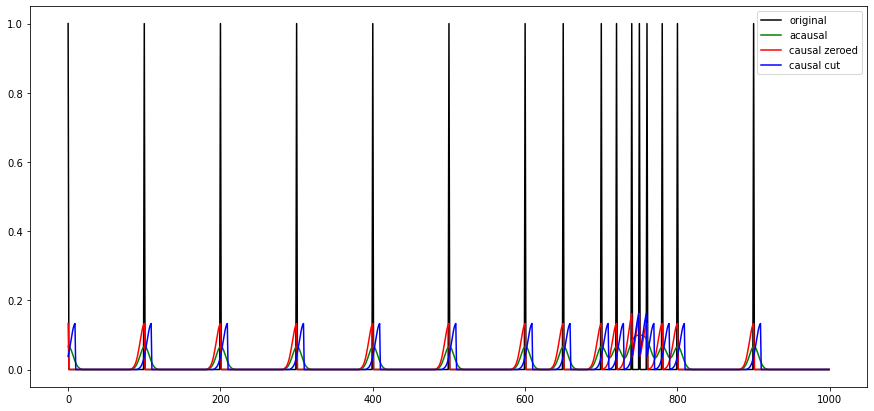

In [199]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

gauss_bin_std = 6  # bins
win_len = int(6 * gauss_bin_std)
window = signal.gaussian(win_len, gauss_bin_std, sym=True)
window /= np.sum(window)

causal_window = window.copy()
causal_window[len(causal_window) // 2:] = 0
causal_window /= np.sum(causal_window)

cut_causal_window = window.copy()
cut_causal_window = cut_causal_window[:len(cut_causal_window) // 2]
cut_causal_window /= np.sum(cut_causal_window)

data_tr = [0 for i in range(1000)]
for i in range(0, 1000, 100):
    data_tr[i] = 1
for i in range(600, 800, 50):
    data_tr[i] = 1
for i in range(700, 800, 20):
    data_tr[i] = 1

ac_smth = signal.convolve(data_tr, window, mode='same')
c_smth  = signal.convolve(data_tr, causal_window, mode='same')
cc_smth = signal.convolve(data_tr, cut_causal_window, mode='same')

# print('original      ', [f'{i:0.2f}' for i in data_tr])
# print('acausal       ', [f'{i:0.2f}' for i in ac_smth])
# print('causal zeroed ', [f'{i:0.2f}' for i in c_smth] )
# print('causal cut    ', [f'{i:0.2f}' for i in cc_smth])

plt_1 = plt.figure(figsize=(15, 7))

plt.plot(data_tr, label='original', color='black')
plt.plot(ac_smth, label='acausal', color='g')
plt.plot(c_smth,  label='causal zeroed', color='r')
plt.plot(cc_smth, label='causal cut', color='b')

plt.legend()

In [ ]:
plt_1 = plt.figure(figsize=(10, 5))
plt.plot(data_ts, label='test', color='r')
plt.plot(data_tr, label='train', color='b')
plt.legend()

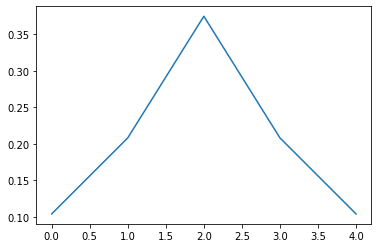

In [18]:
plt.plot(window/np.sum(window))

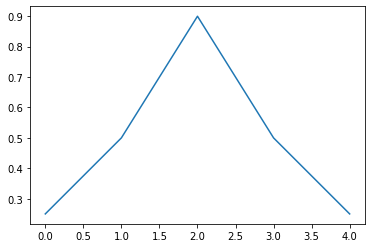

In [6]:
plt.plot(window)

In [1]:
speed = np.linalg.norm(dataset_train.data.finger_vel, axis=1)
dataset_train.data['speed'] = speed
peak_times = dataset_train.calculate_onset(
    'speed', 
    onset_threshold=0.075, 
    peak_prominence=0.5,
    peak_distance_s=0.125,
    multipeak_threshold=0.5
)

speed = np.linalg.norm(dataset_test.data.finger_vel, axis=1)
dataset_test.data['speed'] = speed
peak_times = dataset_test.calculate_onset(
    'speed', 
    onset_threshold=0.075, 
    peak_prominence=0.5,
    peak_distance_s=0.125,
    multipeak_threshold=0.5
)
# speed = np.linalg.norm(dataset_train.data.finger_vel, axis=1)
# dataset_train.data['speed'] = speed
# peak_times = dataset_train.calculate_onset(
#     'speed', 
#     onset_threshold=0.075, 
#     peak_prominence=0.5,
#     peak_distance_s=0.1,
#     multipeak_threshold=0.5
# )

# speed = np.linalg.norm(dataset_test.data.finger_vel, axis=1)
# dataset_test.data['speed'] = speed
# peak_times = dataset_test.calculate_onset(
#     'speed', 
#     onset_threshold=0.075, 
#     peak_prominence=0.5,
#     peak_distance_s=0.1,
#     multipeak_threshold=0.5
# )

# train_trial_data = dataset_train.make_trial_data(align_field='start_time', align_range=(0, 900), allow_nans=False, allow_overlap=True)
train_trial_data = dataset_train.make_trial_data(align_field='speed_onset', align_range=(-290, 600), allow_nans=False, allow_overlap=False)
print(len(train_trial_data.trial_id.unique()))

# test_trial_data = dataset_test.make_trial_data(align_field='start_time', align_range=(0, 900), allow_nans=False, allow_overlap=True)
test_trial_data = dataset_test.make_trial_data(align_field='speed_onset', align_range=(-290, 600), allow_nans=False, allow_overlap=False)
print(len(test_trial_data.trial_id.unique()))


fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plt.xlabel('Time relative to Movement Onset (ms)')
plt.ylabel('Speed (mm/s)')
plt.ylim([0, 550])
plt.title('Aligned Finger Speed Profiles of Trials (Moderate Exclusion)')
first_train, first_test = False, False
for tid, trial in train_trial_data.groupby('trial_id'):
    speed = np.linalg.norm(trial.finger_vel, axis=1)
    ax.plot(range(-290,len(speed)-290), speed, color='tab:blue', label='Training Set Trials (n=200)' if not first_train else None) #row=0, col=0
    first_train = True
for tid, trial in test_trial_data.groupby('trial_id'):
    speed = np.linalg.norm(trial.finger_vel, axis=1)
    ax.plot(range(-290,len(speed)-290), speed, color='tab:red', label='Test Set Trials (n=80)' if not first_test else None) #row=0, col=0
    first_test = True
plt.plot([0 for i in range(1000)], [i for i in range(1000)], linestyle='dotted', color='black', label='Trial Start (Movement Onset)')
plt.plot([425 for i in range(1000)], [i for i in range(1000)], linestyle='dashed', color='black', label='Trial End')


plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig('moderate_exclusion.png', facecolor='white', transparent=False)

NameError: name 'np' is not defined

Shortened 1 trials to prevent overlap.
Shortened 1 trials to prevent overlap.


126
47


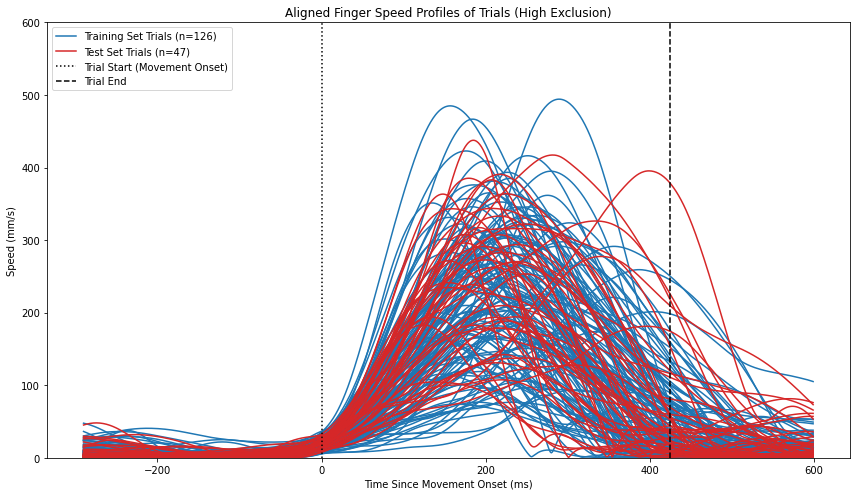

In [20]:
speed = np.linalg.norm(dataset_train.data.finger_vel, axis=1)
dataset_train.data['speed'] = speed
peak_times = dataset_train.calculate_onset(
    'speed', 
    onset_threshold=0.075, 
    peak_prominence=0.1,
    peak_distance_s=0.1,
    multipeak_threshold=0.2
)

speed = np.linalg.norm(dataset_test.data.finger_vel, axis=1)
dataset_test.data['speed'] = speed
peak_times = dataset_test.calculate_onset(
    'speed', 
    onset_threshold=0.075, 
    peak_prominence=0.1,
    peak_distance_s=0.1,
    multipeak_threshold=0.2
)

# train_trial_data = dataset_train.make_trial_data(align_field='start_time', align_range=(0, 900), allow_nans=False, allow_overlap=True)
train_trial_data = dataset_train.make_trial_data(align_field='speed_onset', align_range=(-290, 600), allow_nans=False, allow_overlap=False)
print(len(train_trial_data.trial_id.unique()))

# test_trial_data = dataset_test.make_trial_data(align_field='start_time', align_range=(0, 900), allow_nans=False, allow_overlap=True)
test_trial_data = dataset_test.make_trial_data(align_field='speed_onset', align_range=(-290, 600), allow_nans=False, allow_overlap=False)
print(len(test_trial_data.trial_id.unique()))


fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plt.xlabel('Time Since Movement Onset (ms)')
plt.ylabel('Speed (mm/s)')
plt.ylim([0, 600])
plt.title('Aligned Finger Speed Profiles of Trials (High Exclusion)')
first_train, first_test = False, False
for tid, trial in train_trial_data.groupby('trial_id'):
    speed = np.linalg.norm(trial.finger_vel, axis=1)
    ax.plot(range(-290,len(speed)-290), speed, color='tab:blue', label='Training Set Trials (n=126)' if not first_train else None) #row=0, col=0
    first_train = True
for tid, trial in test_trial_data.groupby('trial_id'):
    speed = np.linalg.norm(trial.finger_vel, axis=1)
    ax.plot(range(-290,len(speed)-290), speed, color='tab:red', label='Test Set Trials (n=47)' if not first_test else None) #row=0, col=0
    first_test = True
plt.plot([0 for i in range(1000)], [i for i in range(1000)], linestyle='dotted', color='black', label='Trial Start (Movement Onset)')
plt.plot([425 for i in range(1000)], [i for i in range(1000)], linestyle='dashed', color='black', label='Trial End')


plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig('high_exclusion.png', facecolor='white', transparent=False)

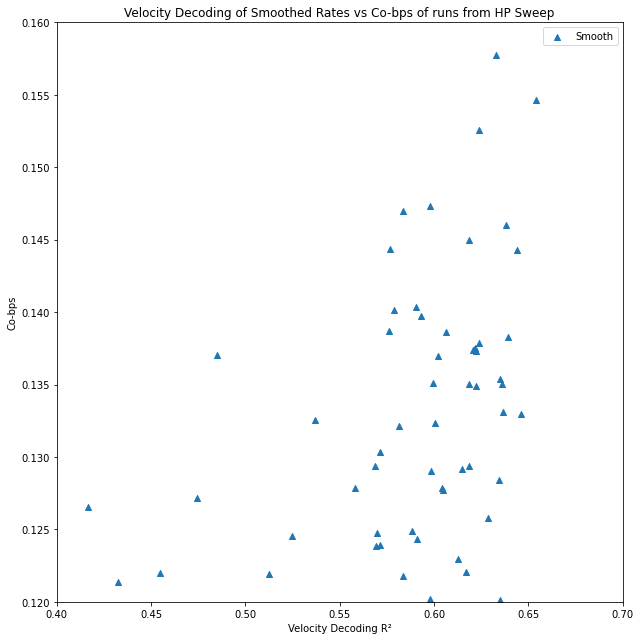

In [46]:
import pandas
import torch
import scipy.signal as signal
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from create_local_data import make_test_data
from configs.default_config import get_config_from_file
from setup import set_device, set_seeds
import h5py
from nlb_tools.make_tensors import h5_to_dict
import sys
import shutil
import numpy as np
import matplotlib.pyplot as plt
import os

df = pandas.read_csv('/home/dmifsud/Projects/NDT-U/cobps_vs_decoding_new_val.csv')
smth_std = 60
lag = 40

fig, ax = plt.subplots(1, 1, figsize=(9, 9), sharex=True, sharey=True)

plt.xlabel("Velocity Decoding R²")
plt.ylabel("Co-bps")
plt.title("Velocity Decoding of Smoothed Rates vs Co-bps of runs from HP Sweep")

ax.scatter(df['Smooth Decoding'], df['Co-bps'], marker='^', c='tab:blue', label='Smooth')
# ax.scatter(df['Original Decoding'], df['Co-bps'], marker='^', c='tab:blue', label='Original')
ax.set_ylim([0.12, 0.16])
ax.set_xlim([0.4, 0.7])
# ax.scatter(df['Smooth Decoding'], df['Co-bps'], marker='^', c='tab:red', label='Smoothed')
# plt.legend()
plt.tight_layout()
plt.savefig('old_lag_vel_decoding_vs_co_bps.png', facecolor='white', transparent=False)

Shortened 88 trials to prevent overlap.
Shortened 31 trials to prevent overlap.


402
138


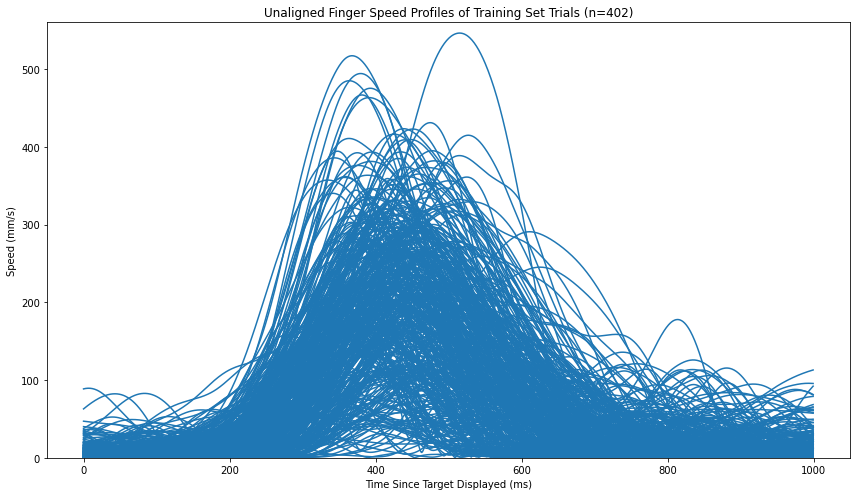

In [14]:

from turtle import pos


train_trial_data = dataset_train.make_trial_data(align_field='start_time', align_range=(0, 1000), allow_nans=False, allow_overlap=False)
# train_trial_data = dataset_train.make_trial_data(align_field='speed_onset', align_range=(-290, 400), allow_nans=False, allow_overlap=True)
print(len(train_trial_data.trial_id.unique()))

test_trial_data = dataset_test.make_trial_data(align_field='start_time', align_range=(0, 1000), allow_nans=False, allow_overlap=False)
# test_trial_data = dataset_test.make_trial_data(align_field='speed_onset', align_range=(-290, 400), allow_nans=False, allow_overlap=True)
print(len(test_trial_data.trial_id.unique()))

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plt.xlabel('Time Since Target Displayed (ms)')
plt.ylabel('Speed (mm/s)')
plt.ylim([0, 560])
plt.title('Unaligned Finger Speed Profiles of Training Set Trials (n=402)')
first_train, first_test = False, False
for tid, trial in train_trial_data.groupby('trial_id'):
    speed = np.linalg.norm(trial.finger_vel, axis=1)
    ax.plot(range(len(speed)), speed, color='tab:blue', label='Training Set Trials (n=402)' if not first_train else None) #row=0, col=0
    first_train = True
# for tid, trial in test_trial_data.groupby('trial_id'):
#     speed = np.linalg.norm(trial.finger_vel, axis=1)
#     ax.plot(range(len(speed)), speed, color='tab:red', label='Test Set Trials (n=134)' if not first_test else None) #row=0, col=0
#     first_test = True

# plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig('training_set.png', facecolor='white', transparent=False)

Shortened 88 trials to prevent overlap.
Shortened 31 trials to prevent overlap.


402
138


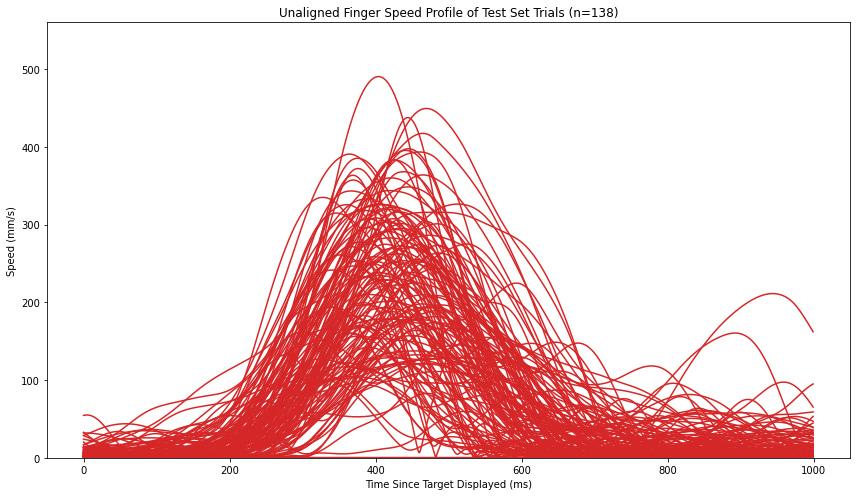

In [15]:

train_trial_data = dataset_train.make_trial_data(align_field='start_time', align_range=(0, 1000), allow_nans=False, allow_overlap=False)
# train_trial_data = dataset_train.make_trial_data(align_field='speed_onset', align_range=(-290, 400), allow_nans=False, allow_overlap=True)
print(len(train_trial_data.trial_id.unique()))

test_trial_data = dataset_test.make_trial_data(align_field='start_time', align_range=(0, 1000), allow_nans=False, allow_overlap=False)
# test_trial_data = dataset_test.make_trial_data(align_field='speed_onset', align_range=(-290, 400), allow_nans=False, allow_overlap=True)
print(len(test_trial_data.trial_id.unique()))

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plt.xlabel('Time Since Target Displayed (ms)')
plt.ylabel('Speed (mm/s)')
plt.ylim([0, 560])
plt.title('Unaligned Finger Speed Profile of Test Set Trials (n=138)')
first_train, first_test = False, False
# for tid, trial in train_trial_data.groupby('trial_id'):
#     speed = np.linalg.norm(trial.finger_vel, axis=1)
#     ax.plot(range(len(speed)), speed, color='tab:blue', label='Training Set Trials (n=383)' if not first_train else None) #row=0, col=0
#     first_train = True
for tid, trial in test_trial_data.groupby('trial_id'):
    speed = np.linalg.norm(trial.finger_vel, axis=1)
    ax.plot(range(len(speed)), speed, color='tab:red', label='Test Set Trials (n=134)' if not first_test else None) #row=0, col=0
    first_test = True

# plt.legend()
plt.tight_layout()

plt.savefig('test_set.png', facecolor='white', transparent=False)

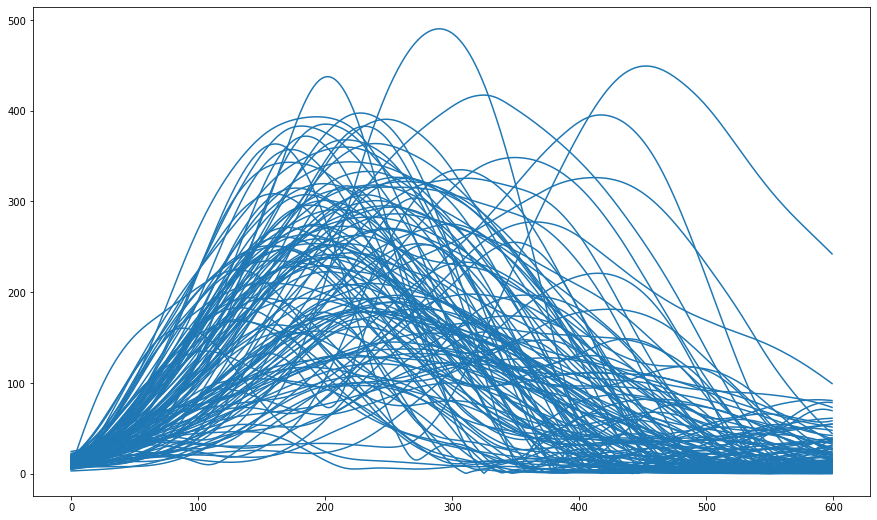

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))

for tid, trial in test_trial_data.groupby('trial_id'):
    speed = np.linalg.norm(trial.finger_vel, axis=1)
    # angle = dataset.trial_info[dataset.trial_info.trial_id == tid].reach_angle
    ax.plot(range(len(speed)), speed, color='tab:blue') #row=0, col=0
    
    
    # ax[0].plot(range(len(trial.finger_vel.x)), trial.finger_vel.x, color='tab:blue') #row=0, col=0
    # ax[1].plot(range(len(trial.finger_vel.y)), trial.finger_vel.y, color='tab:blue') #row=1, col=0
    # ax[0].plot(range(len(trial.finger_vel.x)), trial.finger_vel.x, f'{colors.rgb2hex(mapper.to_rgba(angle))}') #row=0, col=0
    # ax[1].plot(range(len(trial.finger_vel.y)), trial.finger_vel.y, f'{colors.rgb2hex(mapper.to_rgba(angle))}') #row=1, col=0
plt.savefig('Vel.png', transparent=False)

In [27]:
for i in range(0, 10000, 50):
    print(i * 10) 

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
8500

In [23]:
test

['0ms',
 '0ms',
 '0ms',
 '0ms',
 '0ms',
 '0ms',
 '0ms',
 '0ms',
 '0ms',
 '0ms',
 '0ms',
 '0ms',
 '0ms',
 '0ms',
 '0ms',
 '0ms',
 '0ms',
 '0ms',
 '0ms',
 '0ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '1ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '2ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '3ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '4ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '5ms',
 '6ms',
 '6ms',
 '6ms',
 '6ms',
 '6ms',


In [ ]:
normal:
122
46

In [109]:
train_trial_data.target_pos.x.isnull().sum()

100

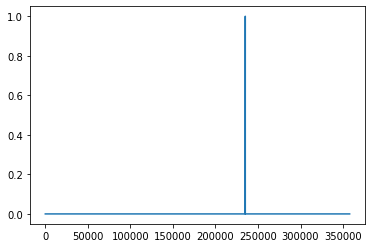

In [110]:
plt.plot(train_trial_data.target_pos.x.isnull())

In [99]:
test_trial_data.spikes.isnull().sum()

201     0
203     0
204     0
301     0
401     0
       ..
9403    0
9501    0
9502    0
9601    0
9602    0
Length: 130, dtype: int64

In [80]:
test_trial_data

align_time             clock_time cursor_pos             \
                                                                x          y   
0      -1 days +23:59:59.710000 0 days 00:08:07.302000  -5.985406  84.220655   
1      -1 days +23:59:59.711000 0 days 00:08:07.303000  -5.969928  84.251227   
2      -1 days +23:59:59.712000 0 days 00:08:07.304000  -5.954293  84.281684   
3      -1 days +23:59:59.713000 0 days 00:08:07.305000  -5.938507  84.312026   
4      -1 days +23:59:59.714000 0 days 00:08:07.306000  -5.922580  84.342249   
...                         ...                    ...        ...        ...   
122815   0 days 00:00:00.595000 0 days 00:10:48.519000  25.360798  14.875709   
122816   0 days 00:00:00.596000 0 days 00:10:48.520000  25.467923  14.908667   
122817   0 days 00:00:00.597000 0 days 00:10:48.521000  25.573124  14.942056   
122818   0 days 00:00:00.598000 0 days 00:10:48.522000  25.676393  14.975850   
122819   0 days 00:00:00.599000 0 days 00:10:48.523000  25.777721  15.010023   

       finger_pos                       finger_vel            margin  ...  \
                x          y          z          x          y         ...   
0       -5.786600  84.400765  89.008600  14.731204  29.125070  False  ...   
1       -5.771891  84.429725  89.000132  14.679526  28.791793  False  ...   
2       -5.757241  84.458348  88.991768  14.615064  28.452103  False  ...   
3       -5.742661  84.486629  88.983515  14.537891  28.106306  False  ...   
4       -5.728165  84.514561  88.975378  14.448077  27.754709  False  ...   
...           ...        ...        ...        ...        ...    ...  ...   
122815  25.368154  15.392614  89.456769  90.936105  28.330905  False  ...   
122816  25.458242  15.421114  89.457472  89.240475  28.661713  False  ...   
122817  25.546635  15.449938  89.458192  87.546576  28.979401  False  ...   
122818  25.633335  15.479073  89.458926  85.852873  29.284474  False  ...   
122819  25.718341  15.508507  89.459670  84.159057  29.577034  False  ...   

       spikes                          target_pos       trial_id  \
         9301 9403 9501 9502 9601 9602          x     y            
0         0.0  0.0  0.0  0.0  0.0  0.0       -7.5  82.5        0   
1         0.0  0.0  0.0  0.0  0.0  0.0       -7.5  82.5        0   
2         0.0  0.0  0.0  0.0  0.0  0.0       -7.5  82.5        0   
3         0.0  0.0  0.0  0.0  0.0  0.0       -7.5  82.5        0   
4         0.0  0.0  0.0  0.0  0.0  0.0       -7.5  82.5        0   
...       ...  ...  ...  ...  ...  ...        ...   ...      ...   
122815    0.0  0.0  0.0  0.0  0.0  0.0       22.5  22.5      137   
122816    0.0  0.0  0.0  0.0  0.0  0.0       22.5  22.5      137   
122817    0.0  0.0  0.0  0.0  0.0  0.0       22.5  22.5      137   
122818    0.0  0.0  0.0  0.0  0.0  0.0       22.5  22.5      137   
122819    0.0  0.0  0.0  0.0  0.0  0.0       22.5  22.5      137   

                     trial_time  
                                 
0      -1 days +23:59:59.710000  
1      -1 days +23:59:59.711000  
2      -1 days +23:59:59.712000  
3      -1 days +23:59:59.713000  
4      -1 days +23:59:59.714000  
...                         ...  
122815   0 days 00:00:00.595000  
122816   0 days 00:00:00.596000  
122817   0 days 00:00:00.597000  
122818   0 days 00:00:00.598000  
122819   0 days 00:00:00.599000  

[122820 rows x 144 columns]

In [55]:
train_trial_data

align_time             clock_time cursor_pos             \
                                                                x          y   
0      -1 days +23:59:59.710000 0 days 00:00:01.062000  56.448884  63.922671   
1      -1 days +23:59:59.711000 0 days 00:00:01.063000  56.461139  63.928560   
2      -1 days +23:59:59.712000 0 days 00:00:01.064000  56.473242  63.934374   
3      -1 days +23:59:59.713000 0 days 00:00:01.065000  56.485189  63.940116   
4      -1 days +23:59:59.714000 0 days 00:00:01.066000  56.496980  63.945788   
...                         ...                    ...        ...        ...   
357775   0 days 00:00:00.595000 0 days 00:08:06.199000  32.796099  89.913044   
357776   0 days 00:00:00.596000 0 days 00:08:06.200000  32.807037  89.943631   
357777   0 days 00:00:00.597000 0 days 00:08:06.201000  32.818570  89.974201   
357778   0 days 00:00:00.598000 0 days 00:08:06.202000  32.830677  90.004773   
357779   0 days 00:00:00.599000 0 days 00:08:06.203000  32.843337  90.035368   

       finger_pos                       finger_vel            margin  ...  \
                x          y          z          x          y         ...   
0       56.461210  63.894241  95.974756  10.805878   6.564702  False  ...   
1       56.471950  63.900763  95.973242  10.676277   6.478495  False  ...   
2       56.482562  63.907198  95.971748  10.548188   6.393202  False  ...   
3       56.493047  63.913549  95.970275  10.421814   6.308782  False  ...   
4       56.503406  63.919816  95.968823  10.297356   6.225197  False  ...   
...           ...        ...        ...        ...        ...    ...  ...   
357775  33.054963  90.068941  88.811132  13.621788  36.951855  False  ...   
357776  33.068705  90.106006  88.810727  13.859651  37.183817  False  ...   
357777  33.082682  90.143308  88.810411  14.092180  37.423723  False  ...   
357778  33.096889  90.180854  88.810180  14.319743  37.669822  False  ...   
357779  33.111322  90.218648  88.810029  14.542416  37.921763  False  ...   

       spikes                          target_pos       trial_id  \
         9301 9403 9501 9502 9601 9602          x     y            
0         0.0  0.0  0.0  0.0  0.0  0.0       52.5  67.5        0   
1         0.0  0.0  0.0  0.0  0.0  0.0       52.5  67.5        0   
2         0.0  0.0  0.0  0.0  0.0  0.0       52.5  67.5        0   
3         0.0  0.0  0.0  0.0  0.0  0.0       52.5  67.5        0   
4         0.0  0.0  0.0  0.0  0.0  0.0       52.5  67.5        0   
...       ...  ...  ...  ...  ...  ...        ...   ...      ...   
357775    0.0  0.0  0.0  0.0  0.0  0.0       37.5  97.5      401   
357776    0.0  0.0  0.0  0.0  0.0  0.0       37.5  97.5      401   
357777    0.0  0.0  0.0  0.0  0.0  0.0       37.5  97.5      401   
357778    0.0  0.0  0.0  0.0  0.0  0.0       37.5  97.5      401   
357779    0.0  0.0  0.0  0.0  0.0  0.0       37.5  97.5      401   

                     trial_time  
                                 
0      -1 days +23:59:59.710000  
1      -1 days +23:59:59.711000  
2      -1 days +23:59:59.712000  
3      -1 days +23:59:59.713000  
4      -1 days +23:59:59.714000  
...                         ...  
357775   0 days 00:00:00.595000  
357776   0 days 00:00:00.596000  
357777   0 days 00:00:00.597000  
357778   0 days 00:00:00.598000  
357779   0 days 00:00:00.599000  

[357780 rows x 144 columns]

In [45]:
len(change_nan)

551

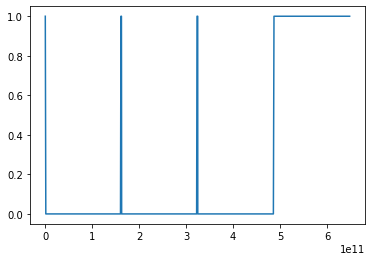

In [66]:
plt.plot(drop_trial_train)

In [61]:
drop_trial[drop_trial == True].index


TimedeltaIndex(['0 days 00:00:00.252000', '0 days 00:02:41.264000',
                '0 days 00:02:42.200000', '0 days 00:02:42.300000',
                '0 days 00:05:23.172000', '0 days 00:05:24.500000',
                '0 days 00:05:24.600000', '0 days 00:08:06.672000',
                '0 days 00:08:06.800000', '0 days 00:08:06.900000',
                ...
                '0 days 00:10:35.864000', '0 days 00:10:36.940000',
                '0 days 00:10:38.236000', '0 days 00:10:39.296000',
                '0 days 00:10:40.652000', '0 days 00:10:41.644000',
                '0 days 00:10:42.864000', '0 days 00:10:43.732000',
                '0 days 00:10:46.496000', '0 days 00:10:47.924000'],
               dtype='timedelta64[ns]', name='clock_time', length=148, freq=None)

In [37]:
len(dataset.data.index > "00:08:06.900000")

649100

In [43]:
len(mask)

551

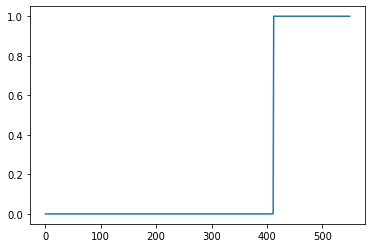

In [33]:
plt.plot(mask)

In [5]:
dataset.trial_info[dataset.trial_info.trial_id == 11].reach_angle

11   -90.0
Name: reach_angle, dtype: float64

In [198]:
dataset.trial_info

,trial_id,start_time,end_time,target_pos,reach_dist_x,reach_dist_y,reach_angle
0,0,0 days 00:00:01.352000,0 days 00:00:02.712000,"[-37.5, 82.5]",-90.0,15.0,170.537678
1,1,0 days 00:00:02.712000,0 days 00:00:03.952000,"[22.5, 67.5]",60.0,-15.0,-14.036243
2,2,0 days 00:00:03.952000,0 days 00:00:05.112000,"[-22.5, 7.5]",-45.0,-60.0,-126.869898
3,3,0 days 00:00:05.112000,0 days 00:00:06.364000,"[-52.5, 67.5]",-30.0,60.0,116.565051
4,4,0 days 00:00:06.364000,0 days 00:00:07.672000,"[-37.5, 52.5]",15.0,-15.0,-45.000000
...,...,...,...,...,...,...,...
535,535,0 days 00:10:41.644000,0 days 00:10:42.864000,"[-52.5, 82.5]",-105.0,0.0,180.000000
536,536,0 days 00:10:42.864000,0 days 00:10:43.732000,"[-22.5, 67.5]",30.0,-15.0,-26.565051
537,537,0 days 00:10:43.732000,0 days 00:10:46.496000,"[-7.5, 7.5]",15.0,-60.0,-75.963757
538,538,0 days 00:10:46.496000,0 days 00:10:47.924000,"[-52.5, 37.5]",-45.0,30.0,146.309932


In [14]:
dataset.resample(10)

In [6]:
axis_labels = f"yaxis: {{title: {{text: 'ch 1',}}, showticklabels: false, fixedrange: true}},\n"
for i in range(2,99):
    axis_labels += f"yaxis{i}: {{title: {{text: 'ch {i}',}}, showticklabels: false, fixedrange: true}},\n"

In [7]:
with open(f"test.txt", "w") as f:
    f.write(axis_labels)

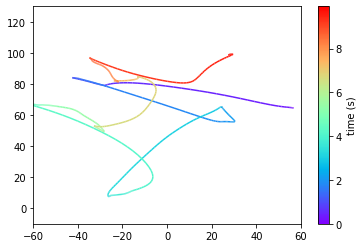

In [27]:
## Plot a few reaches

# Extract start and end times, target positions
start = dataset.trial_info.iloc[0].start_time # arbitrarily using 1st through 6th reaches
end = dataset.trial_info.iloc[7].end_time - pd.Timedelta(1, 'ms')
targets = dataset.trial_info.target_pos.iloc[0:8].to_numpy().tolist()
tts = dataset.trial_info.end_time.iloc[0:8] - start

# Get cursor position data
reach_data = dataset.data.cursor_pos.loc[start:end].to_numpy().reshape(-1, 1, 2)
reach_seg = np.concatenate([reach_data[:-1], reach_data[1:]], axis=1)
# Split into collection of lines for color gradient
lc = LineCollection(reach_seg, cmap='rainbow', norm=plt.Normalize(0, len(reach_seg) * dataset.bin_width / 1000))
lc.set_array(np.arange(len(reach_seg)) * dataset.bin_width / 1000)

# Plot lines and add targets
ax = plt.axes()
lines = ax.add_collection(lc)
# for tt, target in zip(tts, targets):
#     ax.plot(target[0], target[1], marker='o', markersize=8, color=plt.get_cmap('rainbow')(tt.total_seconds() * 1000 / dataset.bin_width / len(reach_seg)))
ax.set_xlim(-60, 60)
ax.set_ylim(-10, 130)
plt.colorbar(lines, label='time (s)')
plt.show()

In [16]:
## Compute speed onset for each reach, for plotting alignment

# Calculate speed and call `calculate_onset`
speed = np.linalg.norm(dataset.data.finger_vel, axis=1)
dataset.data['speed'] = speed
peak_times = dataset.calculate_onset('speed', 0.05)

In [202]:
dataset.trial_info.speed_onset.isnull().sum()

374

In [203]:
540-376

164

In [17]:
## Prep data

# Smooth spikes with 50 ms std Gaussian
dataset.smooth_spk(50, name='smth_50', ignore_nans=True)

# Lag velocity by 120 ms relative to neural data
lag = 120
lag_bins = int(round(lag / dataset.bin_width))
nans = dataset.data.finger_vel.x.isna().reset_index(drop=True)
rates = dataset.data.spikes_smth_50[~nans.to_numpy() & ~nans.shift(-lag_bins, fill_value=True).to_numpy()].to_numpy()
vel = dataset.data.finger_vel[~nans.to_numpy() & ~nans.shift(lag_bins, fill_value=True).to_numpy()].to_numpy()
vel_index = dataset.data.finger_vel[~nans.to_numpy() & ~nans.shift(lag_bins, fill_value=True).to_numpy()].index

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(rates)
test2 = pca.transform(rates)

In [19]:
## Kinematic decoding

# Fit decoder and evaluate
gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 9)})
gscv.fit(rates, vel)
print(f'Decoding R2: {gscv.best_score_}')
pred_vel = gscv.predict(rates)

# Add data back to main dataframe
pred_vel_df = pd.DataFrame(pred_vel, index=vel_index, columns=pd.MultiIndex.from_tuples([('pred_vel', 'x'), ('pred_vel', 'y')]))
dataset.data = pd.concat([dataset.data, pred_vel_df], axis=1)
# Add data back to main dataframe
pred_vel_df = pd.DataFrame(test2, index=vel_index, columns=pd.MultiIndex.from_tuples([('pca', 'x'), ('pca', 'y'),('pca', 'z'),]))
dataset.data = pd.concat([dataset.data, pred_vel_df], axis=1)

Decoding R2: 0.46388753355995893


In [20]:
pred_vel.shape

(64838, 2)

In [22]:
rates.shape

(64838, 130)

In [21]:
vel.shape

(64838, 2)

In [89]:
test2.shape

(64838, 3)

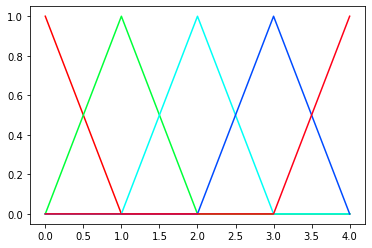

In [172]:
from turtle import color
from matplotlib import cm, colors

norm = colors.Normalize(vmin=-360.0, vmax=360.0, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='hsv')

plt.plot([1,0,0,0,0], color=mapper.to_rgba(-360))
plt.plot([0,1,0,0,0], color=mapper.to_rgba(-90))
plt.plot([0,0,1,0,0], color=mapper.to_rgba(0))
plt.plot([0,0,0,1,0], color=mapper.to_rgba(90))
plt.plot([0,0,0,0,1], color=mapper.to_rgba(360))

In [226]:
min(min([9,4,5]), min([9,8]), min([1,2]))

1

In [7]:
-1-(9*0.05)

-1.45

In [8]:
10+(9*0.05)

10.45

In [89]:
import os
import sys
import h5py
import torch
import numpy as np
import scipy.signal as signal
import plotly.graph_objects as go
from datasets import get_dataloaders
from setup import set_device, set_seeds
from configs.default_config import get_config_from_file
from nlb_tools.make_tensors import h5_to_dict
from nlb_tools.nwb_interface import NWBDataset
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from turtle import color
from matplotlib import cm, colors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
import plotly.graph_objects as go
import numpy as np

In [90]:
norm = colors.Normalize(vmin=-180, vmax=180, clip=True)
hsv_cmap = cm.get_cmap('hsv')
mapper = cm.ScalarMappable(norm=norm, cmap='hsv')
mapper.set_array([])

In [107]:
colors.to_hex(mapper.to_cm())

AttributeError: 'ScalarMappable' object has no attribute 'to_cm'

In [91]:
mapper.to_rgba(180.0)

(1.0, 0.0, 0.09375, 1.0)

In [105]:
mapper.to_hex(180)

AttributeError: 'ScalarMappable' object has no attribute 'to_hex'

In [186]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

rs = np.random.RandomState()
rs.seed(0)

def brownian_motion(T = 1, N = 100, mu = 0.1, sigma = 0.01, S0 = 20):
    dt = float(T)/N
    t = np.linspace(0, T, N)
    W = rs.standard_normal(size = N)
    W = np.cumsum(W)*np.sqrt(dt) # standard brownian motion
    X = (mu-0.5*sigma**2)*t + sigma*W
    S = S0*np.exp(X) # geometric brownian motion
    return S

dates = pd.date_range('2012-01-01', '2013-02-22')
T = (dates.max()-dates.min()).days / 365
N = dates.size
start_price = 100
y = brownian_motion(T, N, sigma=0.1, S0=start_price)
z = brownian_motion(T, N, sigma=0.1, S0=start_price)

fig = go.Figure(data=go.Scatter3d(
    x=dates, y=y, z=z,
    mode='lines',
    # marker=dict(
    #     size=0,
    #     color=z,
    #     colorscale='Viridis',
    # ),
    line=dict(
        color=f'{colors.rgb2hex(mapper.to_rgba(90.0))}',
        width=2
    )
))

fig.update_layout(
    width=1000,
    height=700,
    autosize=False,
    title="PCA of NDT Rates",
    scene=dict(
        xaxis_showspikes=False,
        yaxis_showspikes=False,
        zaxis_showspikes=False,
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=1.23,
                y=1.23,
                z=1.23,
            ),
            center=dict(
                x=0.0,
                y=0.0,
                z=0.0,
            ),
        ),
        aspectratio = dict( x=1, y=1, z=1 ),
        aspectmode = 'manual'
    ),
)
fig.update_layout(margin=dict(r=90, l=0, b=10, t=60))
fig.add_layout_image(
    dict(
        source="https://domenick-m.github.io/NDT-Timing-Test/plots/color_wheel.png",
        xref="paper", yref="paper",
        x=1.09, y=0.01,
        sizex=0.35, sizey=0.35,
        xanchor="right", yanchor="bottom"
    )
)
fig.show()

In [83]:
print(f'╔═══════════════════════════╗\n║ NDT Rates Decoding:       ║\n║   {0.034565:.3f} R\u00b2                ║\n╚═══════════════════════════╝')


╔═══════════════════════════╗
║ NDT Rates Decoding:       ║
║   0.035 R²                ║
╚═══════════════════════════╝


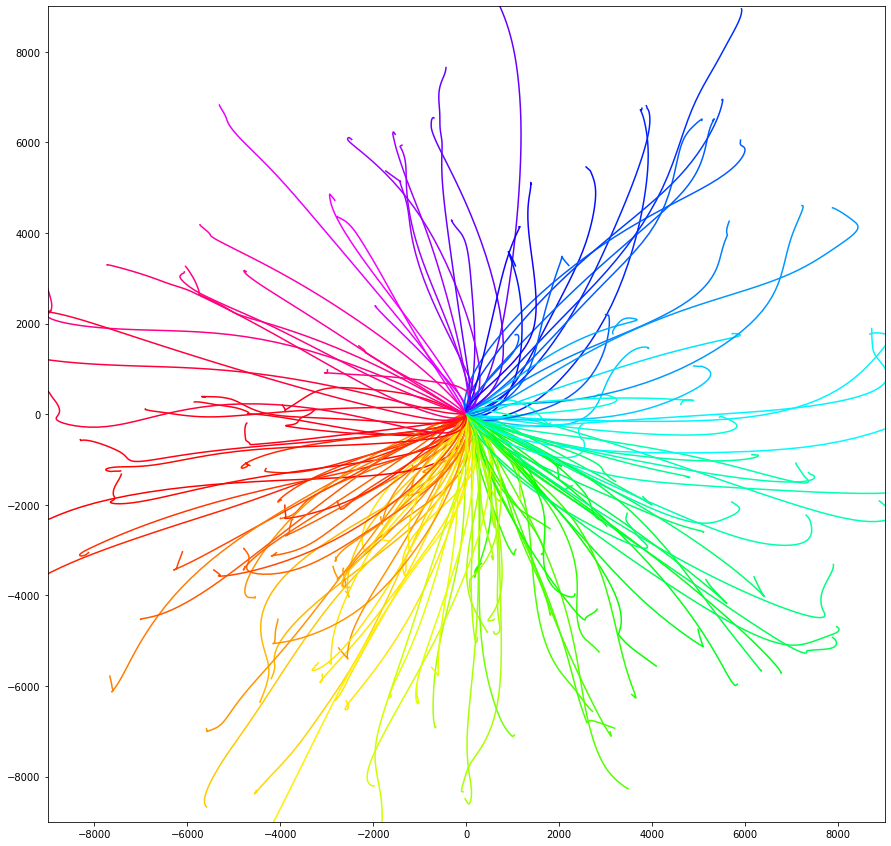

In [25]:
from turtle import color
from matplotlib import cm, colors


max_angle = -1000
min_angle = 1000
for tid, trial in trial_data.groupby('trial_id'):
    angle = dataset.trial_info[dataset.trial_info.trial_id == tid].reach_angle
    if angle.item() < min_angle:
        min_angle = angle.item()
    if angle.item() > max_angle:
        max_angle = angle.item()

norm = colors.Normalize(vmin=min_angle, vmax=max_angle, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='hsv')

fig = plt.figure(figsize=(15,15))
# ax = plt.axes(projection='3d')
plt.xlim([-9000,9000])
plt.ylim([-9000,9000])
# plt.xlim([-500,500])
# plt.ylim([-500,500])
plt.legend()

for tid, trial in trial_data.groupby('trial_id'):
    angle = dataset.trial_info[dataset.trial_info.trial_id == tid].reach_angle
    # plt.plot(trial.finger_vel.x, trial.finger_vel.y, color=mapper.to_rgba(angle), alpha=0.5)
    # ax.plot3D(trial.pca.z, trial.pca.y, trial.pca.x, color=mapper.to_rgba(angle), alpha=0.5)
    plt.plot(np.cumsum(trial.finger_vel.x), np.cumsum(trial.finger_vel.y), color=mapper.to_rgba(angle))
    # plt.plot(np.cumsum(trial.finger_vel.x[29:]), np.cumsum(trial.finger_vel.y[29:]), color=mapper.to_rgba(angle))
        # plt.plot(trial.cursor_pos.x*50, trial.cursor_pos.y*50, color='blue')

In [162]:
max_angle

180.0

In [163]:
min_angle

-170.53767779197437

ValueError: x and y must have same first dimension, but have shapes (105,) and (75,)

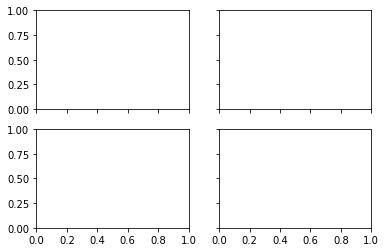

In [24]:
## Plot predicted vs true kinematics

# Coloring function
get_color = lambda idx, series: plt.get_cmap('Greens')((series[idx] - series.min()) / (series.max() - series.min()))
# Extract trial data aligned to movement onset
trial_data = dataset.make_trial_data(align_field='speed_onset', align_range=(0, 750), allow_nans=True)

# Initialize figure
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
# Loop through trials and plot on appropriate subplots
for tid, trial in trial_data.groupby('trial_id'):
    axs[0][0].plot(np.arange(-300, 750, dataset.bin_width), trial.finger_vel.x, color=get_color(tid, dataset.trial_info.reach_dist_x))
    axs[0][1].plot(np.arange(-300, 750, dataset.bin_width), trial.finger_vel.y, color=get_color(tid, dataset.trial_info.reach_dist_y))
    axs[1][0].plot(np.arange(-300, 750, dataset.bin_width), trial.pred_vel.x, color=get_color(tid, dataset.trial_info.reach_dist_x))
    axs[1][1].plot(np.arange(-300, 750, dataset.bin_width), trial.pred_vel.y, color=get_color(tid, dataset.trial_info.reach_dist_y))

# Add labels
axs[0][0].set_title('X velocity')
axs[0][1].set_title('Y velocity')
axs[0][0].set_ylabel('True velocity')
axs[1][0].set_ylabel('Predicted velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after move onset (ms)')
axs[0][0].set_xlim(-300, 750)
plt.show()

In [56]:
trial_data.trial_id

0         11
1         11
2         11
3         11
4         11
        ... 
12445    536
12446    536
12447    536
12448    536
12449    536
Name: trial_id, Length: 12450, dtype: int64

In [59]:
trial_data[trial_data.trial_id == 536]

align_time             clock_time cursor_pos             \
                                                             x          y   
12375        0 days 00:00:00 0 days 00:10:43.060000 -55.344416  81.728261   
12376 0 days 00:00:00.010000 0 days 00:10:43.070000 -55.333628  81.703673   
12377 0 days 00:00:00.020000 0 days 00:10:43.080000 -55.289381  81.654439   
12378 0 days 00:00:00.030000 0 days 00:10:43.090000 -55.182463  81.566332   
12379 0 days 00:00:00.040000 0 days 00:10:43.100000 -54.975719  81.425030   
...                      ...                    ...        ...        ...   
12445 0 days 00:00:00.700000 0 days 00:10:43.760000 -23.210367  66.853473   
12446 0 days 00:00:00.710000 0 days 00:10:43.770000 -23.202352  66.850698   
12447 0 days 00:00:00.720000 0 days 00:10:43.780000 -23.195106  66.848230   
12448 0 days 00:00:00.730000 0 days 00:10:43.790000 -23.188764  66.846155   
12449 0 days 00:00:00.740000 0 days 00:10:43.800000 -23.183508  66.844596   

      finger_pos                       finger_vel            margin  ...  \
               x          y          z          x          y         ...   
12375 -55.301970  81.680040  86.972519   5.981005  -5.672373  False  ...   
12376 -55.211606  81.604772  86.990537  12.596731  -9.587281  False  ...   
12377 -55.039714  81.484685  87.017119  22.327656 -14.588212  False  ...   
12378 -54.754515  81.310601  87.052460  35.238318 -20.316396  False  ...   
12379 -54.325558  81.077429  87.095334  50.971612 -26.322757  False  ...   
...          ...        ...        ...        ...        ...    ...  ...   
12445 -23.213460  66.856753  88.072330   0.991060  -0.414092  False  ...   
12446 -23.204391  66.853060  88.072183   0.821751  -0.324442  False  ...   
12447 -23.196968  66.850238  88.072166   0.669731  -0.242874  False  ...   
12448 -23.190813  66.848120  88.072143   0.572072  -0.185672  False  ...   
12449 -23.185321  66.846428  88.072133   0.536022  -0.157495  False  ...   

      spikes_smth_50                                    target_pos        \
                9301      9403      9501 9502 9601 9602          x     y   
12375       0.062617  0.147081  0.070601  0.0  0.0  0.0      -22.5  67.5   
12376       0.070601  0.147081  0.077674  0.0  0.0  0.0      -22.5  67.5   
12377       0.076481  0.142219  0.081692  0.0  0.0  0.0      -22.5  67.5   
12378       0.079602  0.132961  0.083117  0.0  0.0  0.0      -22.5  67.5   
12379       0.079602  0.120167  0.082161  0.0  0.0  0.0      -22.5  67.5   
...              ...       ...       ...  ...  ...  ...        ...   ...   
12445       0.000000  0.005680  0.006874  0.0  0.0  0.0       -7.5   7.5   
12446       0.000000  0.008820  0.005605  0.0  0.0  0.0       -7.5   7.5   
12447       0.000000  0.013158  0.005605  0.0  0.0  0.0       -7.5   7.5   
12448       0.000000  0.018860  0.006874  0.0  0.0  0.0       -7.5   7.5   
12449       0.000000  0.025972  0.010014  0.0  0.0  0.0       -7.5   7.5   

      trial_id             trial_time  
                                       
12375      536 0 days 00:00:00.190000  
12376      536 0 days 00:00:00.200000  
12377      536 0 days 00:00:00.210000  
12378      536 0 days 00:00:00.220000  
12379      536 0 days 00:00:00.230000  
...        ...                    ...  
12445      536 0 days 00:00:00.890000  
12446      536 0 days 00:00:00.900000  
12447      536 0 days 00:00:00.910000  
12448      536 0 days 00:00:00.920000  
12449      536 0 days 00:00:00.930000  

[75 rows x 277 columns]